In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
#from helper_functions.scan_helper_functions import AdjustedRSquared
#from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated

In [2]:
class AdjustedRSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the adjusted R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquaredSeparated().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquaredSeparated(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [3]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

In [4]:
class AdjustedRSquared(tf.keras.losses.Loss):
    '''
    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquared().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)
        adjusted_r2 = tf.math.reduce_mean(adjusted_r2)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquared(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [5]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

# Config

In [6]:

test_datafile = '/data/project/general/aerosolretriev/aerosol_data/dataset_22_11_2022/data_all_test_fw.h5'


In [7]:
#model_name = 'forward_model'
model_name = 'surrogate_model'

In [8]:

model_dir = '/data/project/general/aerosolretriev/aerosol_results_november_2022/results_27_11_2022/forward_model_fw/models'


In [9]:
#plot_dir = f'../plots/models/{model_name}'
plot_dir = model_dir +'/plots/model'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [10]:
plot_dir

'/data/project/general/aerosolretriev/aerosol_results_november_2022/results_27_11_2022/forward_model_fw/models/plots/model'

In [11]:
test_datafile

'/data/project/general/aerosolretriev/aerosol_data/dataset_22_11_2022/data_all_test_fw.h5'

In [12]:
model_dir

'/data/project/general/aerosolretriev/aerosol_results_november_2022/results_27_11_2022/forward_model_fw/models'

In [13]:
model_name

'surrogate_model'

# Load the model and the data

In [14]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

#surr = KerasSurrogate.load(model_dir, model_name, model_kwargs=kwargs)
#import tensorflow as tf
#tf.keras.backend.set_floatx('float32')

#surr = KerasSurrogate.load(model_dir, model_name)
#surr = KerasSurrogate.load('/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_model0_0/forward_model1','model', model_kwargs=kwargs)

#surr = KerasSurrogate.load('/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_model_ASHA/forward_model3/models','forward_model/surrogate_model', model_kwargs=kwargs)
                           
surr = KerasSurrogate.load('/data/project/general/aerosolretriev/aerosol_results_november_2022/results_21_11_2022/forward_model_GSD101/models','forward_model/surrogate_model', model_kwargs=kwargs)
                            

In [15]:
from tensorflow import keras
#surr = keras.models.load_model('/data/project/general/aerosolretriev/aerosol_results_25_08_2022/forward_model2/models/forward_model')



#surr = keras.models.load_model('/data/project/general/aerosolretriev/aerosol_results_25_08_2022/best_model/')


#surr = keras.models.load_model(model_dir)


In [16]:
dir(surr)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_surrogate',
 '_fit_model',
 '_load_model',
 '_model',
 '_name',
 '_predict_model',
 '_save_model',
 '_version',
 'details',
 'fit',
 'load',
 'model',
 'name',
 'predict',
 'preprocessor_x',
 'preprocessor_y',
 'save',
 'version']

In [17]:
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')
#dvar_test_old = pd.read_hdf(test_datafile1,key = 'dvar')

In [18]:
#dvar_test_old

In [19]:
dvar_test['F11_95']

0        -2.497665
1         2.805750
2         1.062425
3         6.447333
4        -3.116644
            ...   
200622    4.098025
200623    5.967569
200624   -3.305634
200625    0.951676
200626    2.294605
Name: F11_95, Length: 200627, dtype: float64

In [20]:
dvar_test.describe()

F11_10         F11_11         F11_12         F11_13  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean        4.811014       4.667628       4.531405       4.401603   
std         2.646414       2.674113       2.700677       2.726008   
min        -2.692915      -2.946939      -3.157447      -3.351920   
25%         2.673127       2.530836       2.394488       2.262893   
50%         4.814943       4.673355       4.537723       4.403848   
75%         6.965639       6.829064       6.700060       6.578024   
max        10.447789      10.432858      10.416513      10.398757   

              F11_14         F11_15         F11_16         F11_17  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean        4.277658       4.159064       4.045347       3.936223   
std         2.749962       2.772481       2.793656       2.813525   
min        -3.529915      -3.702799      -3.865789      -4.016521   
25%         2.139283       2.023718       1.908156       1.798899   
50%         4.280359       4.158835       4.046078       3.938152   
75%         6.460660       6.347025       6.241986       6.138432   
max        10.379594      10.359028      10.337061      10.313698   

              F11_18         F11_19  ...        PPF_161        PPF_162  \
count  200627.000000  200627.000000  ...  200627.000000  200627.000000   
mean        3.831650       3.731542  ...       0.031549       0.028935   
std         2.831921       2.848729  ...       0.035510       0.033687   
min        -4.156391      -4.286604  ...      -0.844466      -0.873247   
25%         1.696184       1.598126  ...       0.020776       0.018953   
50%         3.831813       3.729012  ...       0.032643       0.030087   
75%         6.039013       5.944001  ...       0.044992       0.040992   
max        10.288945      10.262806  ...       0.673249       0.645960   

             PPF_163        PPF_164        PPF_165        PPF_166  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean        0.026397       0.023937       0.021557       0.019260   
std         0.031888       0.030119       0.028361       0.026605   
min        -0.881257      -0.865280      -0.830214      -0.803567   
25%         0.017208       0.015521       0.013906       0.012356   
50%         0.027576       0.025095       0.022650       0.020240   
75%         0.037073       0.033276       0.029607       0.026087   
max         0.657848       0.677888       0.683028       0.688446   

             PPF_167        PPF_168        PPF_169        PPF_170  
count  200627.000000  200627.000000  200627.000000  200627.000000  
mean        0.017049       0.014930       0.012909       0.010990  
std         0.024839       0.023020       0.021111       0.019107  
min        -0.755955      -0.819228      -0.831756      -0.770511  
25%         0.010877       0.009462       0.008129       0.006871  
50%         0.017885       0.015611       0.013422       0.011338  
75%         0.022739       0.019588       0.016646       0.013916  
max         0.747714       0.786011       0.792743       0.768043  

[8 rows x 304 columns]

dvar = pd.read_hdf(datafile, key='dvar')
qoi = pd.read_hdf(datafile, key='qoi')

n_in = dvar.shape[1]

dvar_trainval, dvar_test, qoi_trainval, qoi_test = train_test_split(dvar,
                                                                    qoi,
                                                                    test_size=0.2)
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

dvar_trainval.reset_index(drop=True, inplace=True)
qoi_trainval.reset_index(drop=True, inplace=True)

kf = KFold(n_splits=5, random_state=76, shuffle=True)

train_ind, val_ind = next(kf.split(dvar_trainval))

dvar_train = dvar_trainval.values[train_ind]
dvar_val = dvar_trainval.values[val_ind]
qoi_train = qoi_trainval.values[train_ind]
qoi_val = qoi_trainval.values[val_ind]

In [21]:
#surr.evaluate(dvar_test,qoi_test)

In [22]:
dvar_test

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0       1.849627  1.606297  1.380296  1.169623  0.972640  0.787980  0.614495   
1       6.628660  6.530736  6.436893  6.346727  6.259893  6.176093  6.095069   
2       3.753348  3.732465  3.710022  3.686108  3.660808  3.634204  3.606380   
3       8.992801  8.946110  8.899912  8.854235  8.809095  8.764502  8.720455   
4       2.772375  2.559648  2.332314  2.092193  1.841557  1.583258  1.320877   
...          ...       ...       ...       ...       ...       ...       ...   
200622  8.494608  8.151921  7.836840  7.553027  7.301177  7.079378  6.883997   
200623  9.741480  9.663413  9.583731  9.502881  9.421238  9.339119  9.256789   
200624 -0.009030 -0.281812 -0.522337 -0.737506 -0.932055 -1.109268 -1.271499   
200625  5.268869  5.093596  4.928592  4.772670  4.624858  4.484347  4.350458   
200626  3.889094  3.878964  3.867947  3.856064  3.843334  3.829780  3.815426   

          F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163  \
0       0.451206  0.297266  0.151948  ...  0.020661  0.018675  0.016788   
1       6.016597  5.940477  5.866535  ...  0.068337  0.063213  0.058022   
2       3.577413  3.547381  3.516358  ...  0.062548  0.056812  0.051247   
3       8.676948  8.633973  8.591521  ...  0.053980  0.048672  0.043606   
4       1.058812  0.802238  0.556842  ...  0.019644  0.018876  0.018432   
...          ...       ...       ...  ...       ...       ...       ...   
200622  6.710707  6.555307  6.414196  ...  0.017990  0.016136  0.014389   
200623  9.174478  9.092379  9.010660  ...  0.032240  0.029740  0.027248   
200624 -1.420516 -1.557711 -1.684229  ...  0.014924  0.013384  0.011930   
200625  4.222616  4.100327  3.983163  ...  0.027269  0.024901  0.022604   
200626  3.800296  3.784414  3.767807  ...  0.042345  0.038157  0.034164   

         PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0       0.014998  0.013304  0.011706  0.010204  0.008796  0.007482  0.006262  
1       0.052804  0.047604  0.042464  0.037432  0.032552  0.027870  0.023430  
2       0.045875  0.040718  0.035796  0.031127  0.026730  0.022621  0.018817  
3       0.038789  0.034227  0.029927  0.025895  0.022137  0.018658  0.015463  
4       0.018217  0.018120  0.018022  0.017807  0.017374  0.016644  0.015570  
...          ...       ...       ...       ...       ...       ...       ...  
200622  0.012750  0.011218  0.009793  0.008473  0.007257  0.006141  0.005123  
200623  0.024774  0.022331  0.019931  0.017591  0.015324  0.013149  0.011082  
200624  0.010562  0.009279  0.008077  0.006961  0.005930  0.004985  0.004121  
200625  0.020380  0.018233  0.016168  0.014190  0.012305  0.010519  0.008842  
200626  0.030371  0.026782  0.023404  0.020238  0.017291  0.014565  0.012065  

[200627 rows x 304 columns]

In [23]:
dvar_test.describe()

F11_10         F11_11         F11_12         F11_13  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean        4.811014       4.667628       4.531405       4.401603   
std         2.646414       2.674113       2.700677       2.726008   
min        -2.692915      -2.946939      -3.157447      -3.351920   
25%         2.673127       2.530836       2.394488       2.262893   
50%         4.814943       4.673355       4.537723       4.403848   
75%         6.965639       6.829064       6.700060       6.578024   
max        10.447789      10.432858      10.416513      10.398757   

              F11_14         F11_15         F11_16         F11_17  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean        4.277658       4.159064       4.045347       3.936223   
std         2.749962       2.772481       2.793656       2.813525   
min        -3.529915      -3.702799      -3.865789      -4.016521   
25%         2.139283       2.023718       1.908156       1.798899   
50%         4.280359       4.158835       4.046078       3.938152   
75%         6.460660       6.347025       6.241986       6.138432   
max        10.379594      10.359028      10.337061      10.313698   

              F11_18         F11_19  ...        PPF_161        PPF_162  \
count  200627.000000  200627.000000  ...  200627.000000  200627.000000   
mean        3.831650       3.731542  ...       0.031549       0.028935   
std         2.831921       2.848729  ...       0.035510       0.033687   
min        -4.156391      -4.286604  ...      -0.844466      -0.873247   
25%         1.696184       1.598126  ...       0.020776       0.018953   
50%         3.831813       3.729012  ...       0.032643       0.030087   
75%         6.039013       5.944001  ...       0.044992       0.040992   
max        10.288945      10.262806  ...       0.673249       0.645960   

             PPF_163        PPF_164        PPF_165        PPF_166  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean        0.026397       0.023937       0.021557       0.019260   
std         0.031888       0.030119       0.028361       0.026605   
min        -0.881257      -0.865280      -0.830214      -0.803567   
25%         0.017208       0.015521       0.013906       0.012356   
50%         0.027576       0.025095       0.022650       0.020240   
75%         0.037073       0.033276       0.029607       0.026087   
max         0.657848       0.677888       0.683028       0.688446   

             PPF_167        PPF_168        PPF_169        PPF_170  
count  200627.000000  200627.000000  200627.000000  200627.000000  
mean        0.017049       0.014930       0.012909       0.010990  
std         0.024839       0.023020       0.021111       0.019107  
min        -0.755955      -0.819228      -0.831756      -0.770511  
25%         0.010877       0.009462       0.008129       0.006871  
50%         0.017885       0.015611       0.013422       0.011338  
75%         0.022739       0.019588       0.016646       0.013916  
max         0.747714       0.786011       0.792743       0.768043  

[8 rows x 304 columns]

In [24]:
dvar_test.columns

Index(['F11_10', 'F11_11', 'F11_12', 'F11_13', 'F11_14', 'F11_15', 'F11_16',
       'F11_17', 'F11_18', 'F11_19',
       ...
       'PPF_161', 'PPF_162', 'PPF_163', 'PPF_164', 'PPF_165', 'PPF_166',
       'PPF_167', 'PPF_168', 'PPF_169', 'PPF_170'],
      dtype='object', length=304)

# Predict

In [25]:
dvar_test.columns

Index(['F11_10', 'F11_11', 'F11_12', 'F11_13', 'F11_14', 'F11_15', 'F11_16',
       'F11_17', 'F11_18', 'F11_19',
       ...
       'PPF_161', 'PPF_162', 'PPF_163', 'PPF_164', 'PPF_165', 'PPF_166',
       'PPF_167', 'PPF_168', 'PPF_169', 'PPF_170'],
      dtype='object', length=304)

In [26]:
dvar_test

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0       1.849627  1.606297  1.380296  1.169623  0.972640  0.787980  0.614495   
1       6.628660  6.530736  6.436893  6.346727  6.259893  6.176093  6.095069   
2       3.753348  3.732465  3.710022  3.686108  3.660808  3.634204  3.606380   
3       8.992801  8.946110  8.899912  8.854235  8.809095  8.764502  8.720455   
4       2.772375  2.559648  2.332314  2.092193  1.841557  1.583258  1.320877   
...          ...       ...       ...       ...       ...       ...       ...   
200622  8.494608  8.151921  7.836840  7.553027  7.301177  7.079378  6.883997   
200623  9.741480  9.663413  9.583731  9.502881  9.421238  9.339119  9.256789   
200624 -0.009030 -0.281812 -0.522337 -0.737506 -0.932055 -1.109268 -1.271499   
200625  5.268869  5.093596  4.928592  4.772670  4.624858  4.484347  4.350458   
200626  3.889094  3.878964  3.867947  3.856064  3.843334  3.829780  3.815426   

          F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163  \
0       0.451206  0.297266  0.151948  ...  0.020661  0.018675  0.016788   
1       6.016597  5.940477  5.866535  ...  0.068337  0.063213  0.058022   
2       3.577413  3.547381  3.516358  ...  0.062548  0.056812  0.051247   
3       8.676948  8.633973  8.591521  ...  0.053980  0.048672  0.043606   
4       1.058812  0.802238  0.556842  ...  0.019644  0.018876  0.018432   
...          ...       ...       ...  ...       ...       ...       ...   
200622  6.710707  6.555307  6.414196  ...  0.017990  0.016136  0.014389   
200623  9.174478  9.092379  9.010660  ...  0.032240  0.029740  0.027248   
200624 -1.420516 -1.557711 -1.684229  ...  0.014924  0.013384  0.011930   
200625  4.222616  4.100327  3.983163  ...  0.027269  0.024901  0.022604   
200626  3.800296  3.784414  3.767807  ...  0.042345  0.038157  0.034164   

         PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0       0.014998  0.013304  0.011706  0.010204  0.008796  0.007482  0.006262  
1       0.052804  0.047604  0.042464  0.037432  0.032552  0.027870  0.023430  
2       0.045875  0.040718  0.035796  0.031127  0.026730  0.022621  0.018817  
3       0.038789  0.034227  0.029927  0.025895  0.022137  0.018658  0.015463  
4       0.018217  0.018120  0.018022  0.017807  0.017374  0.016644  0.015570  
...          ...       ...       ...       ...       ...       ...       ...  
200622  0.012750  0.011218  0.009793  0.008473  0.007257  0.006141  0.005123  
200623  0.024774  0.022331  0.019931  0.017591  0.015324  0.013149  0.011082  
200624  0.010562  0.009279  0.008077  0.006961  0.005930  0.004985  0.004121  
200625  0.020380  0.018233  0.016168  0.014190  0.012305  0.010519  0.008842  
200626  0.030371  0.026782  0.023404  0.020238  0.017291  0.014565  0.012065  

[200627 rows x 304 columns]

In [27]:
qoi_pred = surr.predict(dvar_test)
qoi_pred = pd.DataFrame(data=qoi_pred, columns=qoi_test.columns)

In [28]:
qoi_pred.describe()

Vtot       RmedianV            GSD              n  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean        4.273428       6.545757      -0.221686      -0.510344   
std         2.463082       1.131677       0.825734       0.993954   
min        -0.315739       4.549228      -6.765918     -11.118750   
25%         2.134502       5.562895      -0.620814      -0.892641   
50%         4.274850       6.534396       0.022606      -0.203246   
75%         6.411429       7.528843       0.413222       0.202633   
max         8.651566       8.810586       0.790693       1.481968   

                   k  
count  200627.000000  
mean       -0.219566  
std         1.005306  
min       -13.376487  
25%        -0.611098  
50%         0.091948  
75%         0.496624  
max         0.938804

In [29]:
qoi_pred = np.exp(qoi_pred)
qoi_pred['GSD'] = qoi_pred['GSD']+1
qoi_pred['n']=qoi_pred['n']+1.33

qoi_test = np.exp(qoi_test)
qoi_test['GSD'] = qoi_test['GSD']+1
qoi_test['n'] = qoi_test['n']+1.33

In [30]:
qoi_test.describe()

Vtot       RmedianV            GSD              n  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean      587.351560    1230.899877       2.027502       2.165983   
std      1060.949067    1266.867639       0.563576       0.482509   
min         1.000001     100.000233       1.020001       1.330006   
25%         8.340444     262.571070       1.540704       1.746560   
50%        70.608817     683.763555       2.028538       2.166892   
75%       596.459319    1827.293834       2.516822       2.583562   
max      4999.903442    4999.999424       2.999996       2.999992   

                   k  
count  200627.000000  
mean        1.101993  
std         0.634267  
min         0.000004  
25%         0.553113  
50%         1.103379  
75%         1.651524  
max         2.199990

In [31]:
qoi_pred.describe()


Vtot       RmedianV            GSD              n  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean      599.673700    1240.116972       2.020407       2.144819   
std      1083.444956    1272.171939       0.556743       0.468170   
min         0.729250      94.559374       1.001152       1.330015   
25%         8.452833     260.576236       1.537507       1.739573   
50%        71.869380     688.417560       2.022864       2.146077   
75%       608.762858    1860.951767       2.511681       2.554623   
max      5719.097367    6704.848918       3.204924       5.731599   

                   k  
count  200627.000000  
mean        1.093101  
std         0.631511  
min         0.000002  
25%         0.542755  
50%         1.096307  
75%         1.643165  
max         2.556921

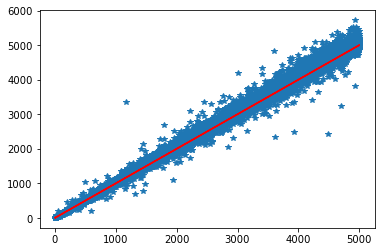

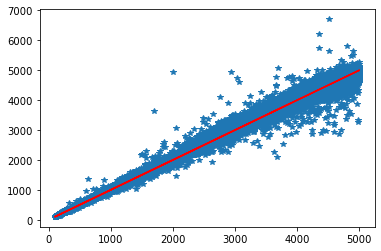

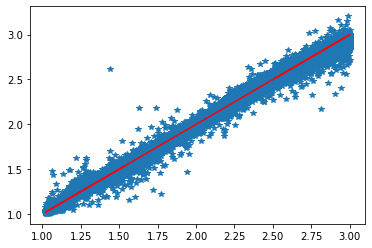

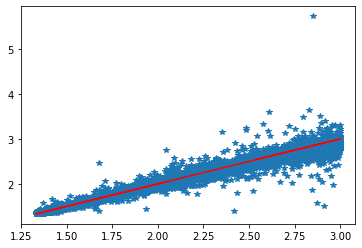

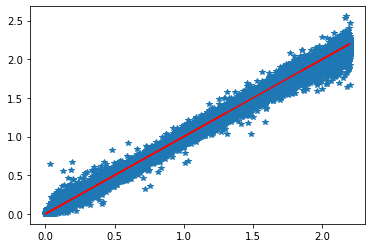

In [32]:

for col in qoi_pred.keys():
    plt.figure()
    plt.plot(qoi_test[col],qoi_pred[col],"*")
    plt.plot(qoi_test[col],qoi_test[col],'r')

In [33]:
# Mean absolute error
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

In [34]:
for col in qoi_pred.keys():
    MAE = mean_absolute_error(qoi_test[col],qoi_pred[col])
    col_mean = qoi_test[col].mean()
    col_p = MAE / col_mean *100
    print(col,'***',MAE,'***', col_mean,'***',col_p)

Vtot *** 15.259467196318012 *** 587.3515602644364 *** 2.59801254115132
RmedianV *** 26.95338489065858 *** 1230.8998772468415 *** 2.189730081941784
GSD *** 0.01832418471120741 *** 2.027501829695972 *** 0.903781414291259
n *** 0.026064351194545803 *** 2.1659827010425925 *** 1.2033499243553407
k *** 0.02238317719461975 *** 1.101992536077113 *** 2.0311550633817963


In [35]:
for col in qoi_pred.keys():
    RMSE = np.sqrt(mean_squared_error(qoi_test[col],qoi_pred[col]))
    col_mean = qoi_test[col].mean()
    col_p = MAE / col_mean *100
    print(col,'***',MAE,'***', col_mean,'***',col_p)

Vtot *** 0.02238317719461975 *** 587.3515602644364 *** 0.003810865367335099
RmedianV *** 0.02238317719461975 *** 1230.8998772468415 *** 0.0018184401191658488
GSD *** 0.02238317719461975 *** 2.027501829695972 *** 1.1039781501936379
n *** 0.02238317719461975 *** 2.1659827010425925 *** 1.0333959354267068
k *** 0.02238317719461975 *** 1.101992536077113 *** 2.0311550633817963


In [36]:
for col in qoi_pred.keys():
    EVS = explained_variance_score(qoi_test[col],qoi_pred[col])
    print(col, EVS)

Vtot 0.9984082235699766
RmedianV 0.997806699098388
GSD 0.9977518022500279
n 0.9951885103765551
k 0.9974562359480722


# Calculate metrics

In [37]:
qoi_pred.describe()

Vtot       RmedianV            GSD              n  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean      599.673700    1240.116972       2.020407       2.144819   
std      1083.444956    1272.171939       0.556743       0.468170   
min         0.729250      94.559374       1.001152       1.330015   
25%         8.452833     260.576236       1.537507       1.739573   
50%        71.869380     688.417560       2.022864       2.146077   
75%       608.762858    1860.951767       2.511681       2.554623   
max      5719.097367    6704.848918       3.204924       5.731599   

                   k  
count  200627.000000  
mean        1.093101  
std         0.631511  
min         0.000002  
25%         0.542755  
50%         1.096307  
75%         1.643165  
max         2.556921

In [38]:
qoi_test.describe()

Vtot       RmedianV            GSD              n  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean      587.351560    1230.899877       2.027502       2.165983   
std      1060.949067    1266.867639       0.563576       0.482509   
min         1.000001     100.000233       1.020001       1.330006   
25%         8.340444     262.571070       1.540704       1.746560   
50%        70.608817     683.763555       2.028538       2.166892   
75%       596.459319    1827.293834       2.516822       2.583562   
max      4999.903442    4999.999424       2.999996       2.999992   

                   k  
count  200627.000000  
mean        1.101993  
std         0.634267  
min         0.000004  
25%         0.553113  
50%         1.103379  
75%         1.651524  
max         2.199990

In [39]:
res = qoi_test - qoi_pred

q = np.arange(0.1, 1.0, 0.05)
q = np.append(q, [0.98, 0.99])
q = np.round(q, decimals=3)
quantiles = res.abs().quantile(q)
quantiles.to_csv(f'{plot_dir}/forward_prediction_residual_quantiles_by_longitudinal_pos.csv', sep='\t')

In [40]:
metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj = metric.call(qoi_test.values, qoi_pred.values).numpy()
r2_adj = pd.Series(data=r2_adj, index=qoi_test.columns)
r2_adj = np.round(r2_adj, decimals=2)
r2_adj = pd.DataFrame(r2_adj).T

In [41]:
r2_adj = pd.DataFrame(r2_adj)

In [42]:
r2_adj

Vtot  RmedianV  GSD     n    k
0   1.0       1.0  1.0  0.99  1.0

In [43]:
min(r2_adj.min())

0.99

In [44]:
qoi_test.describe()

Vtot       RmedianV            GSD              n  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean      587.351560    1230.899877       2.027502       2.165983   
std      1060.949067    1266.867639       0.563576       0.482509   
min         1.000001     100.000233       1.020001       1.330006   
25%         8.340444     262.571070       1.540704       1.746560   
50%        70.608817     683.763555       2.028538       2.166892   
75%       596.459319    1827.293834       2.516822       2.583562   
max      4999.903442    4999.999424       2.999996       2.999992   

                   k  
count  200627.000000  
mean        1.101993  
std         0.634267  
min         0.000004  
25%         0.553113  
50%         1.103379  
75%         1.651524  
max         2.199990

In [45]:
qoi_pred.describe()

Vtot       RmedianV            GSD              n  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean      599.673700    1240.116972       2.020407       2.144819   
std      1083.444956    1272.171939       0.556743       0.468170   
min         0.729250      94.559374       1.001152       1.330015   
25%         8.452833     260.576236       1.537507       1.739573   
50%        71.869380     688.417560       2.022864       2.146077   
75%       608.762858    1860.951767       2.511681       2.554623   
max      5719.097367    6704.848918       3.204924       5.731599   

                   k  
count  200627.000000  
mean        1.093101  
std         0.631511  
min         0.000002  
25%         0.542755  
50%         1.096307  
75%         1.643165  
max         2.556921

In [46]:
qoi_test = qoi_test.reset_index(drop = True)
qoi_test

Vtot     RmedianV       GSD         n         k
0         13.015390  3902.389359  2.514280  2.051410  1.306648
1        252.439632   524.264614  2.973663  1.970619  0.303071
2         13.376742   170.847066  1.670880  2.216621  0.593480
3       2957.924938   162.410655  2.860058  2.605006  0.693317
4          4.552963   826.648880  1.311619  1.971972  0.193914
...             ...          ...       ...       ...       ...
200622  4561.727899  1549.585776  1.470582  1.630395  1.562767
200623  4386.496470   397.012150  1.812444  2.990050  1.261359
200624     5.547257  3567.271097  1.602648  2.453403  1.772999
200625   133.997982  1806.669784  2.832140  2.721851  0.903474
200626    19.724803   117.365263  1.539103  2.535471  1.853659

[200627 rows x 5 columns]

In [47]:
error = qoi_pred - qoi_test
error

Vtot   RmedianV       GSD         n         k
0       -0.010081  52.115490  0.010354  0.015499 -0.029314
1        1.975679  -9.457223 -0.018733 -0.026072 -0.002967
2        0.200165  -2.196026  0.005798 -0.011775 -0.008458
3        0.444415   0.768102 -0.098658 -0.039827 -0.003474
4        0.014847  14.519368 -0.002447 -0.037122 -0.007179
...           ...        ...       ...       ...       ...
200622  -8.988000 -11.414898 -0.020141 -0.001741 -0.042455
200623  75.400884   0.401507  0.014955 -0.038166  0.010747
200624  -0.020154  24.283820 -0.005954 -0.030180 -0.020770
200625   6.146927  51.464665  0.006695 -0.029207 -0.019365
200626   0.193445  -1.269366 -0.004133 -0.007354  0.022943

[200627 rows x 5 columns]

In [48]:
abs_error = np.abs(qoi_test-qoi_pred)
abs_error = pd.DataFrame(abs_error, columns=qoi_test.columns).abs()
abs_error.reset_index(drop=True, inplace=True)
abs_error

Vtot   RmedianV       GSD         n         k
0        0.010081  52.115490  0.010354  0.015499  0.029314
1        1.975679   9.457223  0.018733  0.026072  0.002967
2        0.200165   2.196026  0.005798  0.011775  0.008458
3        0.444415   0.768102  0.098658  0.039827  0.003474
4        0.014847  14.519368  0.002447  0.037122  0.007179
...           ...        ...       ...       ...       ...
200622   8.988000  11.414898  0.020141  0.001741  0.042455
200623  75.400884   0.401507  0.014955  0.038166  0.010747
200624   0.020154  24.283820  0.005954  0.030180  0.020770
200625   6.146927  51.464665  0.006695  0.029207  0.019365
200626   0.193445   1.269366  0.004133  0.007354  0.022943

[200627 rows x 5 columns]

In [49]:
abs_error_table = np.round(abs_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table

Vtot  RmedianV   GSD     n     k
50%    0.99      7.32  0.01  0.02  0.02
75%    9.87     30.65  0.02  0.04  0.03
90%   43.72     74.18  0.04  0.06  0.05
95%   82.36    113.80  0.06  0.07  0.07
99%  199.10    231.96  0.09  0.13  0.11

In [50]:
rel_error = np.abs(qoi_test - qoi_pred) / qoi_test * 100.
rel_error = pd.DataFrame(rel_error, columns=qoi_test.columns).abs()
rel_error.reset_index(drop=True, inplace=True)
rel_error

Vtot  RmedianV       GSD         n         k
0       0.077453  1.335476  0.411821  0.755518  2.243416
1       0.782634  1.803903  0.629973  1.323018  0.978814
2       1.496363  1.285375  0.347004  0.531236  1.425183
3       0.015025  0.472938  3.449501  1.528851  0.501008
4       0.326085  1.756413  0.186526  1.882460  3.702099
...          ...       ...       ...       ...       ...
200622  0.197031  0.736642  1.369580  0.106795  2.716628
200623  1.718932  0.101132  0.825153  1.276430  0.852054
200624  0.363319  0.680739  0.371483  1.230119  1.171483
200625  4.587328  2.848593  0.236396  1.073060  2.143359
200626  0.980722  1.081552  0.268557  0.290058  1.237706

[200627 rows x 5 columns]

In [51]:
rel_error.mean()

Vtot        2.320881
RmedianV    1.727727
GSD         0.874622
n           1.107559
k           3.927421
dtype: float64

In [52]:
rel_error_table = np.round(rel_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table

Vtot  RmedianV   GSD     n      k
50%   1.66      1.22  0.64  0.87   1.73
75%   3.08      2.27  1.15  1.52   3.44
90%   4.99      3.76  1.83  2.26   6.32
95%   6.47      4.93  2.42  2.86   9.32
99%  10.86      8.39  4.30  4.66  24.03

In [53]:
#wMAPE

def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [54]:
wMAPE_qoi = wmape(qoi_test, qoi_pred)
wMAPE_qoi = pd.DataFrame(wMAPE_qoi).T
np.round(wMAPE_qoi, decimals =2)

Vtot  RmedianV  GSD    n     k
0   2.6      2.19  0.9  1.2  2.03

In [55]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n

In [56]:
qoi_test

Vtot     RmedianV       GSD         n         k
0         13.015390  3902.389359  2.514280  2.051410  1.306648
1        252.439632   524.264614  2.973663  1.970619  0.303071
2         13.376742   170.847066  1.670880  2.216621  0.593480
3       2957.924938   162.410655  2.860058  2.605006  0.693317
4          4.552963   826.648880  1.311619  1.971972  0.193914
...             ...          ...       ...       ...       ...
200622  4561.727899  1549.585776  1.470582  1.630395  1.562767
200623  4386.496470   397.012150  1.812444  2.990050  1.261359
200624     5.547257  3567.271097  1.602648  2.453403  1.772999
200625   133.997982  1806.669784  2.832140  2.721851  0.903474
200626    19.724803   117.365263  1.539103  2.535471  1.853659

[200627 rows x 5 columns]

In [57]:
qoi_test['DmedianV']=qoi_test['RmedianV']*2*1e-3 #[um]
qoi_test['DmedianN']=(np.exp(np.log(qoi_test['DmedianV']) - (3*np.log(qoi_test['GSD'])**2))) *1e3   #[nm]
qoi_test['Ntot'] = 6 / np.pi * qoi_test['Vtot']*1e9 / (np.exp((3*np.log(qoi_test['DmedianN'])) + (4.5*np.log(qoi_test['GSD'])**2))) # [cm^-3]
 

In [58]:
qoi_pred['DmedianV']=qoi_pred['RmedianV']*2*1e-3 #[um]
qoi_pred['DmedianN']=(np.exp(np.log(qoi_pred['DmedianV']) - (3*np.log(qoi_pred['GSD'])**2))) *1e3 #[nm] 
qoi_pred['Ntot'] = 6 / np.pi * qoi_pred['Vtot']*1e9 / (np.exp((3*np.log(qoi_pred['DmedianN'])) + (4.5*np.log(qoi_pred['GSD'])**2))) # [cm^-3]


In [59]:
D_array = np.logspace(1, 4.5, 200)  # [nm]


In [60]:
presentation_plot_index = [100,200,300,400,500]

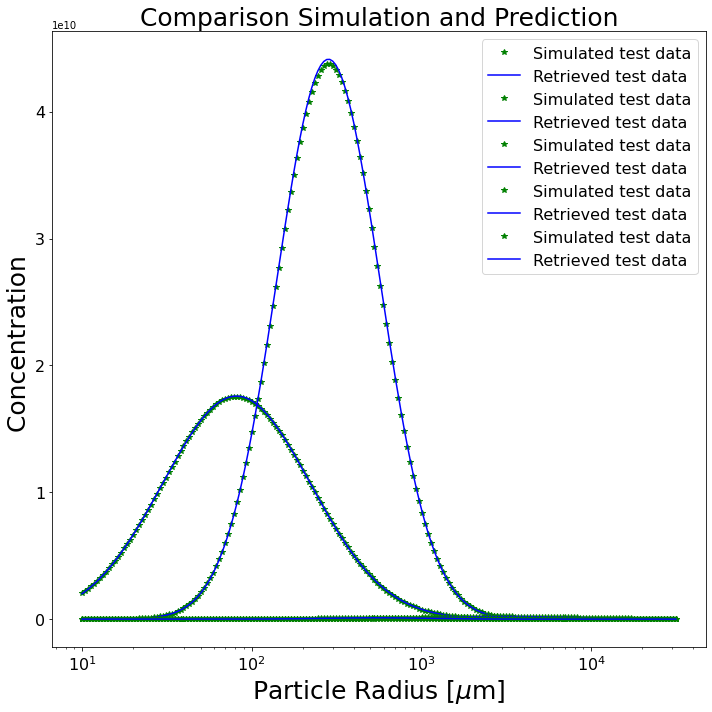

In [61]:
fig, ax = plt.subplots(figsize = (10,10))



for i  in presentation_plot_index:
    
    pdf1 = lognormal(D_array, qoi_test['DmedianN'].loc[i], qoi_test['GSD'].loc[i], qoi_test['Ntot'].loc[i])
    pdf2 = lognormal(D_array, qoi_pred['DmedianN'].loc[i], qoi_pred['GSD'].loc[i], qoi_pred['Ntot'].loc[i])
    
    ax.plot(D_array, pdf1*4/3.*np.pi*D_array**3., '*g', label = 'Simulated test data')
    
    ax.plot(D_array, pdf2*4/3.*np.pi*D_array**3., 'b', label = 'Retrieved test data')
    

    
ax.legend(['Predicted test data', 'test data'], fontsize = 16)
ax.legend(fontsize = 16)   

ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/GSD_GMR_iv.jpg')

In [62]:
import PyMieScatt as pms
from analyzing_functions import *

In [63]:
# Test measurement data:

pymiescatt_df = pd.read_hdf('/data/project/general/aerosolretriev/aerosol_data/dataset_20_10_2022/data_meas_pms.h5',key='qoi')
datafile= '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_values.h5'



In [64]:
qoi_test1 = pd.read_hdf(datafile,'qoi')
dvar_test1 = pd.read_hdf(datafile,'dvar')

In [65]:
qoi_test1_2predict= qoi_test1.copy()
qoi_t1_2predict= qoi_test1.copy()

In [66]:
F11_list_test = [x for x in qoi_test1.columns if 'F11' in x]
PPF_list_test = [x for x in qoi_test1.columns if 'PPF' in x]

In [67]:
angles1 = np.arange(10,86)
angles2 = np.arange(95,171)
angles = np.concatenate([angles1, angles2])

In [68]:
qoi_t1_2predict[F11_list_test]=np.log(qoi_t1_2predict[F11_list_test]/4/np.pi)

In [69]:
qoi_t1_2predict.describe()

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
count     14.000000     14.000000     14.000000     14.000000     14.000000   
mean       2.116040      2.096796      2.081547      2.044796      2.023437   
std        1.145835      1.142867      1.128296      1.107422      1.104294   
min       -0.199561     -0.208397     -0.212769     -0.221579     -0.234253   
25%        1.792529      1.773061      1.822059      1.816952      1.785098   
50%        2.541793      2.496622      2.405367      2.360649      2.345812   
75%        2.891751      2.873745      2.857594      2.695367      2.695968   
max        3.344605      3.322056      3.289388      3.252338      3.225176   

       F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  \
count     14.000000     14.000000     14.000000     14.000000     14.000000   
mean       1.988389      1.937722      1.887792      1.823300      1.749352   
std        1.092429      1.075660      1.066385      1.047664      1.035296   
min       -0.235109     -0.238511     -0.246926     -0.250181     -0.257187   
25%        1.752147      1.671828      1.552562      1.431276      1.286345   
50%        2.325950      2.308480      2.269162      2.132213      1.949157   
75%        2.688048      2.532813      2.475429      2.436740      2.394931   
max        3.172034      3.146335      3.119594      3.058560      3.015682   

       ...  PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  \
count  ...      14.000000      14.000000      14.000000      14.000000   
mean   ...      -0.123218      -0.122365      -0.122719      -0.113935   
std    ...       0.310957       0.286588       0.269080       0.259605   
min    ...      -0.739106      -0.691336      -0.679427      -0.630740   
25%    ...      -0.354765      -0.327652      -0.305333      -0.273248   
50%    ...       0.013856       0.000487      -0.005899      -0.007572   
75%    ...       0.076753       0.073439       0.066282       0.077065   
max    ...       0.239359       0.201787       0.167051       0.162393   

       PPF_0.532_165  PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  \
count      14.000000      14.000000      14.000000      14.000000   
mean       -0.106361      -0.076826      -0.056001      -0.043432   
std         0.238416       0.196173       0.171226       0.157434   
min        -0.600472      -0.533391      -0.463790      -0.395754   
25%        -0.251678      -0.160334      -0.103195      -0.116529   
50%        -0.032275      -0.014585       0.011321       0.029780   
75%         0.056309       0.056260       0.047567       0.054713   
max         0.164037       0.135402       0.116714       0.104993   

       PPF_0.532_169  PPF_0.532_170  
count      14.000000      14.000000  
mean       -0.010453       0.019125  
std         0.148976       0.155659  
min        -0.312426      -0.241548  
25%        -0.097477      -0.065777  
50%         0.045424       0.051092  
75%         0.081514       0.087993  
max         0.174521       0.345749  

[8 rows x 304 columns]

In [70]:
dvar_t1_2predict = surr.predict(qoi_t1_2predict.values)
dvar_t1_2predict = pd.DataFrame(data = dvar_t1_2predict, columns = dvar_test1.columns)
dvar_t1_2predict_2qoi = dvar_t1_2predict.copy()

In [71]:
dvar_t1_2predict['Vtot']=np.exp(dvar_t1_2predict['Vtot'])
dvar_t1_2predict['RmedianV']=np.exp(dvar_t1_2predict['RmedianV'])
dvar_t1_2predict['GSD']=np.exp(dvar_t1_2predict['GSD'])+1
dvar_t1_2predict['n']=np.exp(dvar_t1_2predict['n'])+1.33
dvar_t1_2predict['k']=np.exp(dvar_t1_2predict['k'])

In [72]:
dvar_t1_2predict['RmedianV']=dvar_t1_2predict['RmedianV']*1e-3

In [73]:
dvar_t1_2predict

Vtot  RmedianV       GSD         n         k
0   1.233968  0.090758  1.042789  1.650101  0.214673
1   2.775164  0.161013  1.002714  1.461706  0.003772
2   1.875212  0.296226  1.028639  1.527039  0.009421
3   2.338487  0.372569  1.061334  1.512705  0.002453
4   2.704099  0.213055  1.007665  1.691737  0.002184
5   1.501971  0.102721  1.008775  1.537921  0.477556
6   1.933549  0.126938  1.036303  1.646310  0.145845
7   2.062247  0.167927  1.058194  1.593533  0.089596
8   3.174146  0.155816  1.040169  1.600776  0.232977
9   2.272305  0.171281  1.126263  1.742058  0.263690
10  4.554183  0.236070  1.057750  1.644727  0.267776
11  2.717364  0.272152  1.054207  1.554818  0.186546
12  6.207697  0.306525  1.053164  1.520492  0.416703
13  4.881891  0.640548  1.217089  1.560547  0.501926

In [74]:
dvar_test1

Vtot  RmedianV   GSD     n       k
0   0.843577  0.100463  1.04  1.59  0.0001
1   3.096041  0.251792  1.05  1.59  0.0001
2   1.371784  0.302150  1.05  1.59  0.0001
3   3.522607  0.402867  1.05  1.59  0.0001
4   4.763140  0.503584  1.05  1.59  0.0001
5   2.220050  0.076690  1.09  1.62  0.2230
6   2.081532  0.117591  1.09  1.62  0.2230
7   2.148818  0.152689  1.08  1.62  0.2230
8   3.873357  0.178137  1.08  1.62  0.2230
9   2.463627  0.192627  1.07  1.62  0.2230
10  3.773135  0.229034  1.08  1.62  0.2230
11  2.646380  0.264661  1.08  1.62  0.2230
12  4.618050  0.304148  1.07  1.62  0.2230
13  2.002485  0.394447  1.08  1.62  0.2230

In [75]:
D_array = np.logspace(0.1, 5, 300)  # [nm] base 10
theta = np.arange(0,181,1)

In [76]:
newcolumns = []
F11_newcolumns = []
PPF_newcolumns = []

In [77]:
#compute performance
abs_err_dvar = (dvar_test1 - dvar_t1_2predict).abs()
rel_err_dvar = abs_err_dvar/dvar_test1.abs()*100.
rel_err_dvar

Vtot   RmedianV        GSD         n              k
0    46.278005   9.659884   0.268141  3.779937  214573.409525
1    10.364125  36.052934   4.503430  8.068819    3671.538911
2    36.698733   1.960693   2.034415  3.959809    9320.523173
3    33.614859   7.520624   1.079398  4.861325    2353.161538
4    43.228644  57.692204   4.031951  6.398524    2084.319127
5    32.345167  33.944173   7.451877  5.066584     114.150481
6     7.109342   7.948711   4.926326  1.624068      34.598456
7     4.028765   9.979625   2.019060  1.633764      59.822368
8    18.051810  12.530595   3.688065  1.186662       4.473831
9     7.765866  11.081598   5.258179  7.534429      18.246566
10   20.700222   3.072298   2.060197  1.526350      20.079039
11    2.682300   2.830279   2.388263  4.023552      16.347167
12   34.422469   0.781485   1.573457  6.142455      86.862542
13  143.791686  62.391342  12.693463  3.669921     125.078984

In [78]:
rel_err_dvar.mean(axis = 0)

Vtot           31.505857
RmedianV       18.389032
GSD             3.855444
n               4.248300
k           16605.900836
dtype: float64

In [79]:
rel_err_dvar.std(axis = 0)

Vtot           35.619445
RmedianV       20.668203
GSD             3.192359
n               2.250544
k           57036.722991
dtype: float64

In [80]:
newcolumns = []
F11_newcolumns = []
PPF_newcolumns = []
for i in range(0,181):
    newcolumns.append('F11_'+str(i))
    F11_newcolumns.append('F11_'+str(i))
for j in range(0,181):
    newcolumns.append('PPF_'+str(j))
    PPF_newcolumns.append('PPF_'+str(j))

In [88]:
pymiescatt_pred = pd.DataFrame(columns = newcolumns)

for index in range(14):
    param_tmp = dvar_t1_2predict.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    pms_hdf = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, theta, D_array)
    pymiescatt_pred.loc[index]=np.concatenate([pms_hdf['F11'].T.values,pms_hdf['PPF'].T.values])
   

180.5625265923477
397.18388465207136
322.0197771132856
158.71865376552458
591.0363652101628
17.28426667820254
737.2584439594842
10.96862641441579
426.0356467186673
66.76859863027475
205.3958353866899
330.9320328172907
252.90914187703285
226.97493025272786
332.64571733647824
105.47351675560394
310.18470992075754
201.71392448118857
328.33627996876413
115.04839653707484
467.6970053754824
83.8219463566612
539.772406043062
32.58900524392951
608.1355505908434
52.08192392934379
1141.0209270079579
5.275658927623055


In [89]:
plot_dir

'/data/project/general/aerosolretriev/aerosol_results_november_2022/results_27_11_2022/forward_model_fw/models/plots/model'

In [90]:
pymiescatt_pred.to_csv(f'{plot_dir}/measurement_pred_pms.csv')

In [82]:
dvar_t1_2predict.to_csv(f'{plot_dir}/measurement_pred.csv')

In [83]:
qoi_test

Vtot     RmedianV       GSD         n         k  DmedianV  \
0         13.015390  3902.389359  2.514280  2.051410  1.306648  7.804779   
1        252.439632   524.264614  2.973663  1.970619  0.303071  1.048529   
2         13.376742   170.847066  1.670880  2.216621  0.593480  0.341694   
3       2957.924938   162.410655  2.860058  2.605006  0.693317  0.324821   
4          4.552963   826.648880  1.311619  1.971972  0.193914  1.653298   
...             ...          ...       ...       ...       ...       ...   
200622  4561.727899  1549.585776  1.470582  1.630395  1.562767  3.099172   
200623  4386.496470   397.012150  1.812444  2.990050  1.261359  0.794024   
200624     5.547257  3567.271097  1.602648  2.453403  1.772999  7.134542   
200625   133.997982  1806.669784  2.832140  2.721851  0.903474  3.613340   
200626    19.724803   117.365263  1.539103  2.535471  1.853659  0.234731   

           DmedianN          Ntot  
0        609.302184  2.397003e+00  
1         29.730898  8.759435e+04  
2        154.985204  2.096332e+03  
3         11.827993  2.372221e+07  
4       1325.807964  2.679464e+00  
...             ...           ...  
200622  1983.648900  5.715643e+02  
200623   274.841506  8.217600e+04  
200624  3660.376829  7.938561e-02  
200625   139.929806  7.118215e+02  
200626   134.375517  6.724802e+03  

[200627 rows x 8 columns]

In [84]:
abs_error

Vtot   RmedianV       GSD         n         k
0        0.010081  52.115490  0.010354  0.015499  0.029314
1        1.975679   9.457223  0.018733  0.026072  0.002967
2        0.200165   2.196026  0.005798  0.011775  0.008458
3        0.444415   0.768102  0.098658  0.039827  0.003474
4        0.014847  14.519368  0.002447  0.037122  0.007179
...           ...        ...       ...       ...       ...
200622   8.988000  11.414898  0.020141  0.001741  0.042455
200623  75.400884   0.401507  0.014955  0.038166  0.010747
200624   0.020154  24.283820  0.005954  0.030180  0.020770
200625   6.146927  51.464665  0.006695  0.029207  0.019365
200626   0.193445   1.269366  0.004133  0.007354  0.022943

[200627 rows x 5 columns]

In [85]:
qoi_test.loc[0:100]

Vtot     RmedianV       GSD         n         k  DmedianV  \
0      13.015390  3902.389359  2.514280  2.051410  1.306648  7.804779   
1     252.439632   524.264614  2.973663  1.970619  0.303071  1.048529   
2      13.376742   170.847066  1.670880  2.216621  0.593480  0.341694   
3    2957.924938   162.410655  2.860058  2.605006  0.693317  0.324821   
4       4.552963   826.648880  1.311619  1.971972  0.193914  1.653298   
..           ...          ...       ...       ...       ...       ...   
96      4.408646   222.069743  2.781736  2.641132  1.479516  0.444139   
97   4329.513371  3830.931534  2.043388  1.956501  1.486117  7.661863   
98     59.174873   110.943835  1.177367  2.007306  0.763710  0.221888   
99      8.794782  1985.626779  2.689132  2.250034  1.001771  3.971254   
100   742.073024   111.352464  2.735060  1.558507  1.850297  0.222705   

        DmedianN          Ntot  
0     609.302184  2.397003e+00  
1      29.730898  8.759435e+04  
2     154.985204  2.096332e+03  
3      11.827993  2.372221e+07  
4    1325.807964  2.679464e+00  
..           ...           ...  
96     19.222667  1.067351e+04  
97   1655.753521  1.829976e+02  
98    204.831831  1.166387e+04  
99    210.856357  2.192073e+01  
100    10.684707  1.220982e+07  

[101 rows x 8 columns]

In [86]:
theta_meas = []
for i in range(10,86):
    theta_meas.append(i)
for i in range(95,171):
    theta_meas.append(i)

NameError: name 'pymiescatt_pred' is not defined

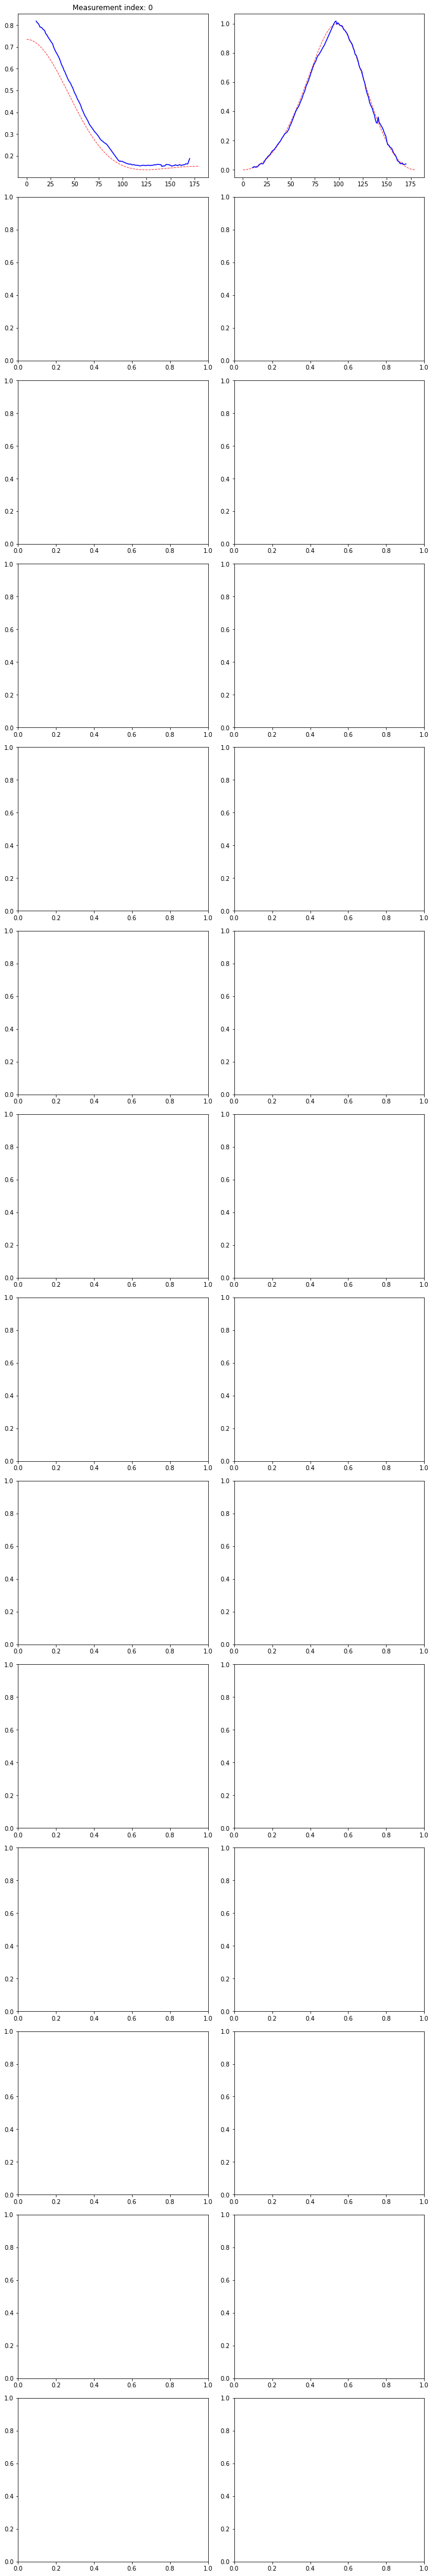

In [87]:
fig, axs = plt.subplots(ncols=2, nrows=14, figsize=(10, 60), constrained_layout=True)
for index in range(14):
    axs[index,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[index,0].plot(theta, pymiescatt_df[F11_newcolumns].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_hdf_plot, = axs[index,1].plot(theta, pymiescatt_df[PPF_newcolumns].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_hdf_plot, = axs[index,0].plot(theta_meas, qoi_test1[F11_list_test].loc[index].values/4/np.pi, c= 'b', label = 'uneph')
    meas_hdf_plot, = axs[index,1].plot(theta_meas, qoi_test1[PPF_list_test].loc[index].values, c= 'b', label = 'uneph')
    
    pms_pred_plot, = axs[index,0].plot(theta, pymiescatt_pred[F11_newcolumns].loc[index], ls='--', lw='1', c='k', alpha=0.8, label='PyMieScatt from INN pred param')
    pms_pred_plot, = axs[index,1].plot(theta, pymiescatt_pred[PPF_newcolumns].loc[index], ls='--', lw='1', c='k', alpha=0.8, label='PyMieScatt from INN pred param')


    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,1].set_ylabel('PPF [-]')
    axs[index,1].set_ylim(-1.1, 1.1)
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot, pms_pred_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/pms_meas_pred.jpg')

In [90]:

testGSD1 = rel_error['GSD'].values
testR = rel_error['RmedianV'].values
testn = rel_error['n'].values
testk = rel_error['k'].values
testVtot = rel_error['Vtot'].values
testGSD2 = np.log(qoi_test['RmedianV'].values)
testGSD3 = np.log(qoi_test['GSD'].values)


In [91]:
qoi_test.describe()

Vtot      RmedianV           GSD             n             k  \
count  97749.000000  97749.000000  97749.000000  97749.000000  97749.000000   
mean     589.221165   1253.357406      2.005892      2.166596      1.099123   
std     1062.277592   1274.351383      0.576283      0.482261      0.634788   
min        1.000001    100.004410      1.010006      1.330009      0.000041   
25%        8.294413    264.926216      1.505792      1.748358      0.550616   
50%       71.190526    713.555706      2.008381      2.168401      1.098514   
75%      603.483745   1877.432328      2.506065      2.583123      1.645923   
max     4999.951069   4999.961197      2.999979      2.999978      2.199983   

           DmedianV      DmedianN          Ntot  
count  97749.000000  97749.000000  9.774900e+04  
mean       2.506715    891.970582  4.357297e+05  
std        2.548703   1449.692579  3.937450e+06  
min        0.200009      5.380719  2.148598e-03  
25%        0.529852     98.027227  1.910241e+01  
50%        1.427111    299.256368  4.875397e+02  
75%        3.754865    956.082708  1.248344e+04  
max        9.999922   9966.663918  2.150251e+08

In [92]:
grid_x, grid_y = np.mgrid[100:5001:1, 1.01:3.1:0.01]

grid_x = np.log(grid_x)
grid_y = np.log(grid_y)

from scipy.interpolate import griddata
grid_GSD = griddata((testGSD2,testGSD3), testGSD1, (grid_x, grid_y), method='nearest')
grid_R = griddata((testGSD2,testGSD3), testR, (grid_x, grid_y), method='nearest')
grid_Vtot = griddata((testGSD2,testGSD3), testVtot, (grid_x, grid_y), method='nearest')
grid_n = griddata((testGSD2,testGSD3), testn, (grid_x, grid_y), method='nearest')
grid_k = griddata((testGSD2,testGSD3), testk, (grid_x, grid_y), method='nearest')

#grid_z1 = griddata((testGSD2,testGSD3), testGSD1, (grid_x, grid_y), method='linear')
#grid_z2 = griddata((testGSD2,testGSD3), testGSD1, (grid_x, grid_y), method='cubic')



In [93]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


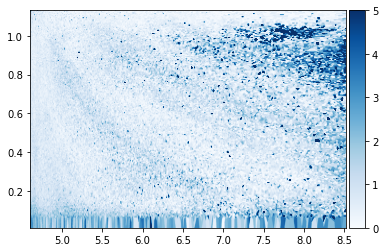

In [94]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_GSD.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')


fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errGSD_GSD_R.jpg')

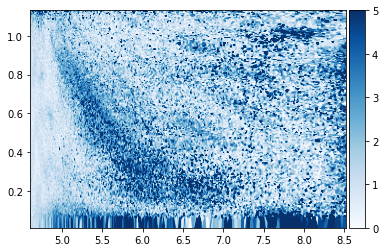

In [95]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_R.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')


fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errR_GSD_R.jpg')

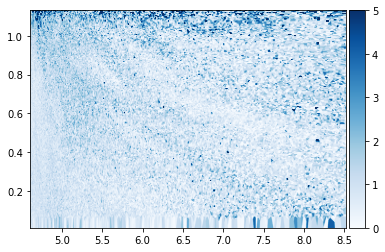

In [96]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_n.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')


fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errn_GSD_R.jpg')

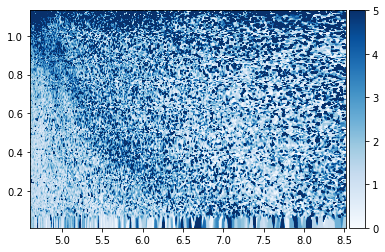

In [97]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_k.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')


fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errk_GSD_R.jpg')

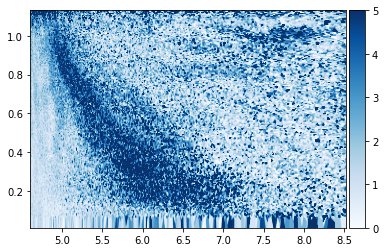

In [98]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_Vtot.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')


fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errVtot_GSD_R.jpg')